In [189]:
import os
from argparse import Namespace
import json

import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import functional as fnn

from train import main

In [191]:
#!g1.1

loss_fn_lst = [fnn.l1_loss, fnn.smooth_l1_loss]#, fnn.mse_loss]

for loss_fn in loss_fn_lst:
    request = Namespace(
        name=loss_fn.__name__,
        data_folder='data',
        data_size=16_000,
        crop_size=256,
        batch_size=64,
        epochs=10,
        learning_rate=0.001,
        gpu=True,
        worker=1
    )
    main(request, loss_fn)

Reading data...


load landmarks...: 100%|██████████| 16000/16000 [00:01<00:00, 10845.20it/s] 


Creating model...


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Tune optimizer...
Use l1_loss!
Ready for training...


validation...: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Epoch # 0:	train loss: 5.5e+01	val loss: 2.2e+02


validation...: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Epoch # 1:	train loss:   8.8	val loss: 9.7e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


Epoch # 2:	train loss:   6.5	val loss: 8.4e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Epoch # 3:	train loss:   6.1	val loss: 5.6e+01


validation...:  94%|█████████▍| 47/50 [00:12<00:00,  3.81it/s]

Epoch # 4:	train loss:   4.3	val loss: 2.7e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


Epoch # 5:	train loss:   3.8	val loss: 2.6e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


Epoch # 6:	train loss:   3.7	val loss: 2.1e+01


validation...: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Epoch # 7:	train loss:   3.4	val loss: 1.9e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


Epoch # 8:	train loss:   3.2	val loss: 1.8e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Epoch # 9:	train loss:   3.1	val loss: 1.7e+01


prediction...: 100%|██████████| 250/250 [01:41<00:00,  2.46it/s]


Create submission...
Reading data...


load landmarks...:  81%|████████  | 12997/16000 [00:00<00:00, 129399.07it/s]

Creating model...
Tune optimizer...
Use smooth_l1_loss!
Ready for training...


validation...: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s]


Epoch # 0:	train loss: 5.5e+01	val loss: 2.1e+02


validation...: 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Epoch # 1:	train loss:   8.3	val loss: 1e+02


validation...: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


Epoch # 2:	train loss:   6.0	val loss: 9.3e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


Epoch # 3:	train loss:   5.2	val loss: 4.2e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


Epoch # 4:	train loss:   3.8	val loss: 2.8e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


Epoch # 5:	train loss:   3.4	val loss: 2.7e+01


validation...: 100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


Epoch # 6:	train loss:   3.2	val loss: 2.3e+01


validation...: 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]

Epoch # 7:	train loss:   3.0	val loss: 1.9e+01



validation...: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


Epoch # 8:	train loss:   2.8	val loss: 1.8e+01


validation...:  98%|█████████▊| 49/50 [00:13<00:00,  3.38it/s]

Epoch # 9:	train loss:   2.7	val loss: 2.1e+01


prediction...: 100%|██████████| 250/250 [01:14<00:00,  3.35it/s]


Create submission...


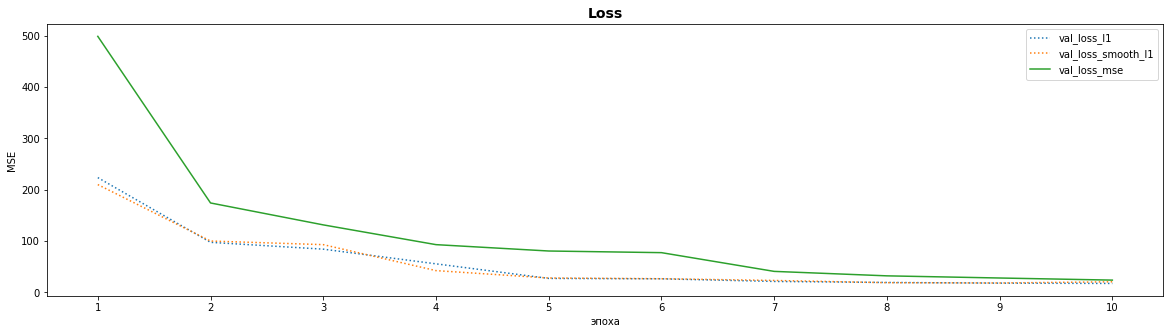

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:828: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)


In [192]:
# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes

for experiment in [
    'loss_l1',
    'loss_smooth_l1',
    'loss_mse'
]:
    
    with open(f'runs/{experiment}/metrics_{experiment}.txt') as f:
        metrics = json.load(f)

    # data
    x = range(1, len(metrics['val_loss']) + 1)
    ls = 'solid' if experiment=='loss_mse' else 'dotted'
    ax.plot(x, metrics['val_loss'], linestyle=ls, label=f'val_{experiment}')

# annotation    
ax.set_title('Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('эпоха')
ax.set_ylabel('MSE')
ax.legend()
ax.set_xticks(range(1, len(metrics['train_loss']) + 1))
#_ = ax.set_ylim([70, 200])